In [4]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_MultiShapeCirclesTranslation as model
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = regdata.organs()
data.build_modules()
data()
source = data.source
target = data.target

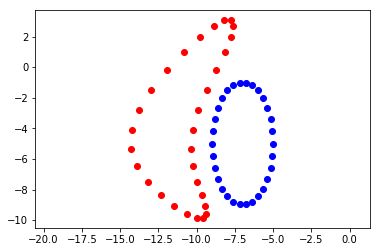

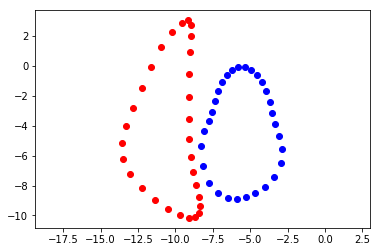

In [6]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [7]:
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]])
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [8]:
print(h)

NameError: name 'h' is not defined

In [20]:
rand_cotan = [[torch.rand(60), torch.rand(2)], [torch.rand(60), torch.rand(2), torch.rand(60)], [torch.rand(60), torch.rand(60)]]
modules.manifold.fill_cotan(rand_cotan)
a=10000
zero_cotan = [[a*torch.rand(60), a*torch.rand(2)], [a*torch.rand(60), a*torch.rand(2), a*torch.rand(60)], [a*torch.rand(60), a*torch.rand(60)]]
modules.manifold.fill_cotan(zero_cotan)

l, h = modules.compute_geodesic_variables_silent(constr_Id)

In [21]:
constr_Id(modules)


tensor([[ 2.2737e-12,  2.5011e-12],
        [ 2.2737e-13,  9.0949e-13],
        [ 2.3306e-12,  2.2737e-13],
        [ 1.2506e-12,  2.5011e-12],
        [ 1.5916e-12,  7.7875e-12],
        [ 3.6380e-12, -2.1600e-12],
        [ 8.1855e-12,  8.1855e-12],
        [ 6.8212e-12,  2.5295e-12],
        [-4.5475e-13,  3.7517e-12],
        [ 0.0000e+00,  9.0949e-13],
        [ 0.0000e+00,  0.0000e+00],
        [ 8.1855e-12, -2.0464e-12],
        [-2.5011e-12,  5.4570e-12],
        [ 2.8084e-12,  2.2737e-12],
        [ 7.9581e-13,  3.6380e-12],
        [-1.1369e-13,  2.2737e-13],
        [-1.8190e-12,  3.4106e-12],
        [-2.2737e-13,  1.1369e-12],
        [ 1.3642e-12,  1.1369e-11],
        [-3.6380e-12,  6.9349e-12],
        [-8.1855e-12,  5.6843e-13],
        [-1.1141e-11, -4.0927e-12],
        [-1.2051e-11, -7.9581e-12],
        [-1.0277e-10,  2.1146e-11],
        [ 9.5497e-11, -7.3214e-11],
        [ 1.0664e-10, -2.0691e-11],
        [ 2.2965e-11,  5.9117e-12],
        [-2.7285e-12,  7.730

In [ ]:
plt.figure()
plt.imshow(constr_Id.constraintsmatrix(modules))
plt.show()

In [ ]:
modules.module_list[0].manifold.numel_gd

In [ ]:
constr_Id = dm.constraints.Identity_Silent()


In [ ]:
constr_Id(modules)

In [ ]:
constr_Id.call_by_matmul(modules).view(-1,2)- constr_Id(modules).view(-1,2)

In [8]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id,source, target, 2, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

cost: [ 0.] attach: 16.183242198688024
 iter : 0  ,total energy: [ 16.1832422]
cost: [ 0.] attach: 16.183242198688024
cost: [ 0.00024123] attach: 15.285173573901009
c 0
 iter : 0  ,total energy: [ 15.28541481]
cost: [ 0.00024123] attach: 15.285173573901009
cost: [ 0.00114817] attach: 14.242818831572473
c 0
 iter : 1  ,total energy: [ 14.243967]
cost: [ 0.00114817] attach: 14.242818831572473
cost: [ 0.00306675] attach: 13.06030608083746
c 0
 iter : 2  ,total energy: [ 13.06337283]
cost: [ 0.00306675] attach: 13.06030608083746
cost: [ 0.00641018] attach: 11.784952393127572
c 0
 iter : 3  ,total energy: [ 11.79136257]
cost: [ 0.00641018] attach: 11.784952393127572
cost: [ 0.01146334] attach: 10.574649381700059
c 0
 iter : 4  ,total energy: [ 10.58611272]
cost: [ 0.01146334] attach: 10.574649381700059
cost: [ 0.01761966] attach: 9.758012130354034
c 0
 iter : 5  ,total energy: [ 9.77563179]
cost: [ 0.01761966] attach: 9.758012130354034
cost: [ 0.02218596] attach: 9.461791021591097
c 0
 iter

cost: [ 0.17685727] attach: 3.1777439287904916
cost: [ 0.17999295] attach: 3.1601691512565244
c 0
 iter : 47  ,total energy: [ 3.3401621]
cost: [ 0.17999295] attach: 3.1601691512565244
cost: [ 0.17997153] attach: 3.147785962554331
c 0
 iter : 48  ,total energy: [ 3.32775749]
cost: [ 0.17997153] attach: 3.147785962554331
cost: [ 0.18462406] attach: 3.141531225043425
c 0
 iter : 49  ,total energy: [ 3.32615529]
cost: [ 0.18462406] attach: 3.141531225043425
cost: [ 0.18194034] attach: 3.229177191173959
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 50  ,total energy: [ 3.41111753]
 iter : 51  ,total energy: tensor([3.4111], grad_fn=<AddBackward0>)


In [ ]:
modules.module_list[1].module_list[0].manifold.gd

In [10]:
X

(tensor([-10.2468,  -4.0937,  -9.8783,  -2.8017,  -9.3228,  -1.4814,  -8.7012,
          -0.1913,  -8.1466,   0.9898,  -7.7684,   1.9745,  -7.6350,   2.6821,
          -7.7764,   3.0520,  -8.1946,   3.0520,  -8.8710,   2.6821,  -9.7684,
           1.9745, -10.8231,   0.9898, -11.9372,  -0.1913, -12.9770,  -1.4814,
         -13.7908,  -2.8017, -14.2468,  -4.0937, -14.2756,  -5.3204, -13.8954,
          -6.4585, -13.2034,  -7.4856, -12.3396,  -8.3731, -11.4463,  -9.0853,
         -10.6406,  -9.5854, -10.0045,  -9.8438,  -9.5863,  -9.8438,  -9.4046,
          -9.5854,  -9.4463,  -9.0853,  -9.6631,  -8.3731,  -9.9673,  -7.4856,
         -10.2413,  -6.4585, -10.3630,  -5.3204,  -8.0000,  -1.0000,  -4.9944,
          -4.9960,  -5.0374,  -4.1638,  -5.1645,  -3.3671,  -5.3706,  -2.6407,
          -5.6469,  -2.0168,  -5.9818,  -1.5229,  -6.3612,  -1.1809,  -6.7688,
          -1.0061,  -7.1869,  -1.0061,  -7.5973,  -1.1809,  -7.9818,  -1.5229,
          -8.3234,  -2.0168,  -8.6066,  -2.6407,  -8

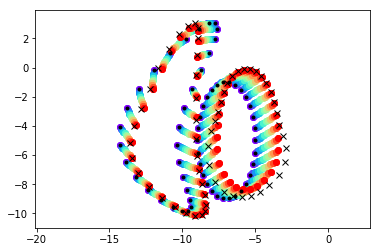

In [16]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
modules.compute_geodesic_variables(constr_Id)
constr_Id(modules)

In [ ]:
H.module.manifold.fill_gd(EnergyFunctional.tensor2list(X[0]))
H.module.manifold.fill_cotan(EnergyFunctional.tensor2list(X[1]))

dm.shooting.shoot_euler(H, it=10)

In [24]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

True

In [30]:
mom = 1000*torch.rand(mom0_tensor.shape)
H.module.manifold.fill_cotan(mom)

dm.shooting.shoot_euler_source(H, source, it=10)

__________________________
tensor([[  4.4409e-14,  -6.1284e-14],
        [  2.7267e-13,   8.0824e-14],
        [  9.3699e-15,   3.0294e-14],
        [  7.7531e-14,   1.9039e-13],
        [ -2.0628e-13,  -9.6616e-14],
        [ -6.3527e-13,  -9.4147e-14],
        [ -3.4678e-13,   1.3678e-13],
        [  3.3223e-13,   1.7764e-15],
        [  6.7057e-14,   1.0569e-13],
        [ -1.1524e-13,   4.9738e-14],
        [  6.8834e-14,  -2.1316e-14],
        [ -1.5277e-13,   1.7497e-13],
        [ -7.4163e-14,  -1.1724e-13],
        [  1.7675e-13,  -2.1760e-14],
        [  6.3238e-13,  -3.5083e-14],
        [ -3.8503e-13,   7.9936e-15],
        [  1.6964e-13,  -1.7097e-13],
        [  2.2204e-15,  -7.9936e-15],
        [ -1.9540e-13,   1.2568e-13],
        [  5.7732e-15,  -5.3735e-14],
        [ -1.6900e-13,  -2.2649e-13],
        [ -2.5702e-14,   8.7930e-13],
        [  4.5658e-13,   3.0242e-13],
        [  7.7433e-13,  -3.7392e-13],
        [ -1.3728e-13,  -1.2035e-13],
        [ -6.3294e-13, 

__________________________
tensor([[ -2.5313e-13,  -5.7288e-14],
        [  1.5099e-14,   7.1720e-14],
        [  9.2973e-15,   3.0665e-14],
        [ -4.8873e-14,  -7.6222e-14],
        [  5.5315e-13,  -6.9477e-15],
        [  1.0547e-13,   7.9936e-15],
        [  3.7192e-14,  -3.7748e-13],
        [ -7.2609e-14,  -8.8818e-16],
        [  7.8382e-14,  -2.5668e-13],
        [  3.1086e-14,  -1.0836e-13],
        [  2.5757e-13,  -1.6875e-14],
        [  5.8620e-14,   1.2701e-13],
        [  2.0961e-13,   1.2879e-14],
        [ -1.2967e-13,   1.2212e-13],
        [  1.3500e-13,  -1.1280e-13],
        [ -4.0723e-13,  -3.5527e-15],
        [ -1.2523e-13,   6.1728e-14],
        [ -1.0258e-13,  -4.0856e-14],
        [  5.6399e-14,   5.9952e-14],
        [  6.7835e-14,  -1.1324e-13],
        [  3.5777e-14,  -6.1551e-13],
        [  1.1802e-13,   4.6052e-13],
        [ -5.1736e-14,   3.7836e-13],
        [ -8.1934e-14,   3.6704e-13],
        [ -1.6548e-13,  -5.9508e-14],
        [ -3.8414e-14, 

([<defmod.manifold.CompoundManifold at 0x7f0e2401bf98>,
 [[[tensor([], requires_grad=True),
    tensor([-231.8666], grad_fn=<ViewBackward>)],
   [tensor([], requires_grad=True),
    tensor([1.3255e-11], grad_fn=<ViewBackward>),
    tensor([0., 0.], grad_fn=<ViewBackward>)],
   [tensor([ 1.8848e+00,  1.8965e+00,  4.3539e+00,  1.5192e+00,  5.6843e-14,
            -3.6948e-13, -4.0359e-11, -3.7949e-10, -2.9468e-04, -2.1583e-04,
            -1.1503e+00, -4.3000e+00, -3.2429e-01, -7.1369e+00,  2.0035e-01,
            -5.9492e+00,  5.2202e-01, -5.3789e+00,  1.0329e+00, -5.6169e+00,
             2.2022e+00, -6.0741e+00,  2.8927e+00, -3.0580e+00,  2.6360e+00,
            -1.4312e-01,  3.5798e+00,  1.4629e+00,  4.3249e+00,  2.7380e+00,
             3.7023e+00,  3.1890e+00,  1.4455e+00,  1.9959e+00,  1.8534e+00,
             3.3379e+00,  1.0869e+00,  3.3236e+00,  5.0781e-01,  2.6815e+00,
            -2.8545e-02,  1.9622e+00,  1.1935e-01, -3.8012e-02,  1.4842e-01,
             1.5292e-01, -6.3014

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):

        return model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param).energy_tensor(gd, mom)
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = mom0_tensor


test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_shooting():
    def shooting(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        
        intermediate_states, intermediate_controls = dm.shooting.shoot_euler(H, it=2)
        return H.module.manifold.unroll_cotan()
    return torch.autograd.gradcheck(shooting, (gd, mom), raise_exception=True,atol=1e-2)

test_gradcheck_shooting()

In [ ]:
def test_gradcheck_attachement():
    def attach(gd, mom):
        reg_param = 10**-3 

        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        energyfunc = model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param)

        return energyfunc.attach() 
    return torch.autograd.gradcheck(attach, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_attachement()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.module.compute_geodesic_variables(constr_Id)
        return H.module.controls[0]
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        return mod.autoaction()
    return torch.autograd.gradcheck(autoaction, (gd, mom), raise_exception=True)

mod = data.modules[0].copy()
gd = torch.cat(mod.manifold.gd.copy())
mom = torch.cat(mod.manifold.cotan.copy())

gd.requires_grad
mom.requires_grad

test_gradcheck_autoaction()